# **Datasets Analysis**

In this notebook, we analyze and compare the three different datasets we decided to use:

* MCTS (without Softmax)
* MCTS (with Softmax)
* Random


### Libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare, chi2

After generating the datasets with MCTS (using and not using Softmax), we decided to split them into four distinct datasets, one for each game state: root, early, mid, and late; for more in-depth analysis. (In the *Random* dataset, we did the opposite process — we generated them already separated, but merged everything into one to allow for more general analysis)


In [29]:
# Load datasets
mcts_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_all.csv")
soft_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_all.csv")

# Function to count pieces (X or O) on the board
def count_pieces(row):
    return sum([1 for val in row[:42] if val in ["X", "O"]])

# Count pieces in each row
mcts_df["piece_count"] = soft_df.apply(count_pieces, axis=1)
soft_df["piece_count"] = soft_df.apply(count_pieces, axis=1)

# Split by game phases (without Softmax)
mcts_root_df = mcts_df[mcts_df["piece_count"].between(0, 3)].copy()
mcts_early_df = mcts_df[mcts_df["piece_count"].between(4, 14)].copy()
mcts_mid_df = mcts_df[mcts_df["piece_count"].between(15, 28)].copy()
mcts_late_df = mcts_df[mcts_df["piece_count"].between(29, 41)].copy()

# Split by game phases (with Softmax)
soft_root_df = soft_df[soft_df["piece_count"].between(0, 3)].copy()
soft_early_df = soft_df[soft_df["piece_count"].between(4, 14)].copy()
soft_mid_df = soft_df[soft_df["piece_count"].between(15, 28)].copy()
soft_late_df = soft_df[soft_df["piece_count"].between(29, 41)].copy()

# Remove the auxiliary "piece_count" column (without Softmax)
for d in [mcts_root_df, mcts_early_df, mcts_mid_df, mcts_late_df]:
    d.drop(columns=["piece_count"], inplace=True)

# Remove the auxiliary "piece_count" column (with Softmax)
for e in [soft_root_df, soft_early_df, soft_mid_df, soft_late_df]:
    e.drop(columns=["piece_count"], inplace=True)

# Save the new datasets (without Softmax)
mcts_root_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_root.csv", index=False)
mcts_early_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_early.csv", index=False)
mcts_mid_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_mid.csv", index=False)
mcts_late_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_late.csv", index=False)

# Save the new datasets (with Softmax)
soft_root_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_root.csv", index=False)
soft_early_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_early.csv", index=False)
soft_mid_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_mid.csv", index=False)
soft_late_df.to_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_late.csv", index=False)


### Datasets

In [30]:
# Datasets without Sotftmax
mcts_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_all.csv")
mcts_root_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_root.csv")
mcts_early_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_early.csv")
mcts_mid_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_mid.csv")
mcts_late_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/mcts_late.csv")

# Datasets with Sotftmax
soft_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_all.csv")
soft_root_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_root.csv")
soft_early_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_early.csv")
soft_mid_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_mid.csv")
soft_late_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/soft_late.csv")

# Datasets Random
random_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/random_all.csv")
random_root_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/random_root.csv")
random_early_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/random_early.csv")
random_mid_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/random_mid.csv")
random_late_df = pd.read_csv("datasets/Dataset_Analysis_(Ze)/datasets/random_late.csv")




In [47]:
# List of datasets, states, iterations
mcts_state_datasets = [mcts_root_df, mcts_early_df, mcts_mid_df, mcts_late_df]
soft_state_datasets = [soft_root_df, soft_early_df, soft_mid_df, soft_late_df]
random_state_datasets = [random_root_df, random_early_df, random_mid_df, random_late_df]
state_labels = ['Root', 'Early', 'Mid', 'Late']
iterations = ['10kIter', '20kIter', '30kIter', '40kIter', '50kIter']
diff_iters = ['10kIter', '20kIter', '30kIter', '40kIter']
reference = '50kIter'
result = ['result']

## Dataset Information

### Duplicates and Equivalents

In [48]:
def check_unique_and_symmetric_reflection(name, df):
    total_boards = len(df)
    print(f"\n### {name.upper()} ###")
    print(f"Total number of boards: {total_boards}")

    # Create board representation as a standard string
    df['board_string'] = df.iloc[:, :42].astype(str).agg(''.join, axis=1)

    # UNIQUE without considering symmetry
    df_unique_raw = df.drop_duplicates(subset='board_string').copy()
    num_unique_raw = len(df_unique_raw)
    num_repeated_raw = total_boards - num_unique_raw
    percent_unique_raw = (num_unique_raw / total_boards) * 100
    percent_repeated_raw = (num_repeated_raw / total_boards) * 100
    print(f"Number of unique boards (without symmetry): {num_unique_raw} ({percent_unique_raw:.2f}%)")
    print(f"Number of repeated boards (without symmetry): {num_repeated_raw} ({percent_repeated_raw:.2f}%)")

    # UNIQUE WITH symmetry (horizontal reflection)
    def canonical_board_string(row):
        board = row[:42].values.reshape(6, 7)
        normal = ''.join(board.flatten())
        flipped = ''.join(np.fliplr(board).flatten())
        return min(normal, flipped)

    df['canonical_board_string'] = df.iloc[:, :42].apply(canonical_board_string, axis=1)
    df_unique_canon = df.drop_duplicates(subset='canonical_board_string').copy()
    num_unique_canon = len(df_unique_canon)
    num_repeated_canon = total_boards - num_unique_canon
    percent_unique_canon = (num_unique_canon / total_boards) * 100
    percent_repeated_canon = (num_repeated_canon / total_boards) * 100

    print(f"Number of unique boards (with horizontal symmetry): {num_unique_canon} ({percent_unique_canon:.2f}%)")
    print(f"Number of repeated boards (with horizontal symmetry): {num_repeated_canon} ({percent_repeated_canon:.2f}%)")


check_unique_and_symmetric_reflection("MCTS (w/o Softmax)", mcts_df)
check_unique_and_symmetric_reflection("MCTS (w/ Softmax)", soft_df)
check_unique_and_symmetric_reflection("Random", random_df)


### MCTS (W/O SOFTMAX) ###
Total number of boards: 85076
Number of unique boards (without symmetry): 8242 (9.69%)
Number of repeated boards (without symmetry): 76834 (90.31%)
Number of unique boards (with horizontal symmetry): 6046 (7.11%)
Number of repeated boards (with horizontal symmetry): 79030 (92.89%)

### MCTS (W/ SOFTMAX) ###
Total number of boards: 83208
Number of unique boards (without symmetry): 44494 (53.47%)
Number of repeated boards (without symmetry): 38714 (46.53%)
Number of unique boards (with horizontal symmetry): 40820 (49.06%)
Number of repeated boards (with horizontal symmetry): 42388 (50.94%)

### RANDOM ###
Total number of boards: 89000
Number of unique boards (without symmetry): 73309 (82.37%)
Number of repeated boards (without symmetry): 15691 (17.63%)
Number of unique boards (with horizontal symmetry): 71541 (80.38%)
Number of repeated boards (with horizontal symmetry): 17459 (19.62%)


The term *"with horizontal symmetry"* refers to the existence of two boards that, although different in board, are equivalent because they are mirror images of each other across the vertical axis.

### Repeated Boards by Game State

In [49]:
# Ensure all sub-datasets contain the 'board_string' column
def ensure_board_string(dataset_list):
    for df in dataset_list:
        if 'board_string' not in df.columns:
            df['board_string'] = df.iloc[:, :42].astype(str).agg(''.join, axis=1)

# Apply to all 3 groups
ensure_board_string(mcts_state_datasets)
ensure_board_string(soft_state_datasets)
ensure_board_string(random_state_datasets)


# Calculate and print percentage of repeated boards by state (w/o Softmax)
print("Percentage of repeated boards by state (w/o Softmax):")
for label, df_state in zip(state_labels, mcts_state_datasets):
    total = len(df_state)
    unique = df_state['board_string'].nunique()
    repeated = total - unique
    percent_repeated = (repeated / total) * 100
    print(f"{label}: {repeated} repeated out of {total} ({percent_repeated:.2f}%)")

print(" ")
print("-----------------------------------------")
print(" ")

# Calculate and print percentage of repeated boards by state (w/ Softmax)
print("Percentage of repeated boards by state (w/ Softmax):")
for label, df_state in zip(state_labels, soft_state_datasets):
    total = len(df_state)
    unique = df_state['board_string'].nunique()
    repeated = total - unique
    percent_repeated = (repeated / total) * 100
    print(f"{label}: {repeated} repeated out of {total} ({percent_repeated:.2f}%)")

print(" ")
print("-----------------------------------------")
print(" ")

# Calculate and print percentage of repeated boards by state (Random)
print("Percentage of repeated boards by state (Random):")
for label, df_state in zip(state_labels, random_state_datasets):
    total = len(df_state)
    unique = df_state['board_string'].nunique()
    repeated = total - unique
    percent_repeated = (repeated / total) * 100
    print(f"{label}: {repeated} repeated out of {total} ({percent_repeated:.2f}%)")

Percentage of repeated boards by state (w/o Softmax):
Root: 8721 repeated out of 11200 (77.87%)
Early: 26017 repeated out of 30796 (84.48%)
Mid: 29100 repeated out of 33783 (86.14%)
Late: 5469 repeated out of 7429 (73.62%)
 
-----------------------------------------
 
Percentage of repeated boards by state (w/ Softmax):
Root: 11140 repeated out of 11200 (99.46%)
Early: 22689 repeated out of 30796 (73.68%)
Mid: 4827 repeated out of 33783 (14.29%)
Late: 58 repeated out of 7429 (0.78%)
 
-----------------------------------------
 
Percentage of repeated boards by state (Random):
Root: 11705 repeated out of 12000 (97.54%)
Early: 3985 repeated out of 33000 (12.08%)
Mid: 1 repeated out of 36000 (0.00%)
Late: 0 repeated out of 8000 (0.00%)


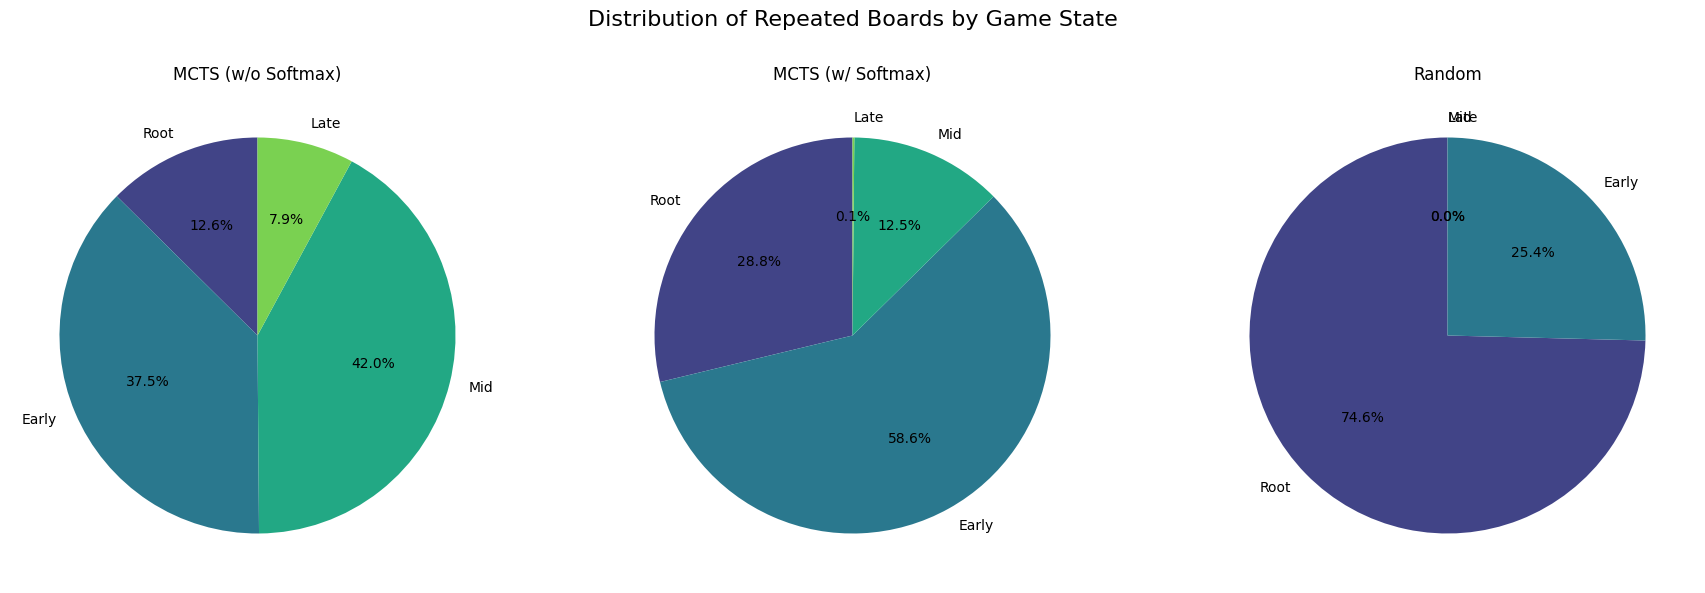

In [50]:
# Function to count repeated boards by state
def get_repeated_counts(state_datasets):
    repeated_counts = []
    for df_state in state_datasets:
        total = len(df_state)
        unique = df_state['board_string'].nunique()
        repeated = total - unique
        repeated_counts.append(repeated)
    return repeated_counts

# Get repeated counts for each dataset type
mcts_repeated = get_repeated_counts(mcts_state_datasets)
soft_repeated = get_repeated_counts(soft_state_datasets)
random_repeated = get_repeated_counts(random_state_datasets)

# Dataset titles
titles = ['MCTS (w/o Softmax)', 'MCTS (w/ Softmax)', 'Random']
repeated_lists = [mcts_repeated, soft_repeated, random_repeated]

# Plot the 3 pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    ax.pie(
        repeated_lists[i],
        labels=state_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis', len(state_labels))
    )
    ax.set_title(f'{titles[i]}')

fig.suptitle('Distribution of Repeated Boards by Game State', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Space for main title
plt.show()

**Note:** It makes sense that the states with the most repeated states are the initial ones, since not only is the number of possible permutations smaller, but it's also in the early stages that more equivalent (i.e., symmetrical) boards are likely to appear.


## Differences in Suggested Moves (10k–50k Iterations)

In [51]:
# Check if all iterations suggest the same move
def check_same_move_all(df, name):
    same_all = df[iterations].nunique(axis=1) == 1
    percent_same = same_all.mean() * 100
    print(f"[{name}] All iterations suggest the same move in {percent_same:.2f}% of the cases.")

# Apply to MCTS without Softmax and with Softmax
check_same_move_all(mcts_df, "MCTS (w/o Softmax)")
check_same_move_all(soft_df, "MCTS (w/ Softmax)")


[MCTS (w/o Softmax)] All iterations suggest the same move in 66.61% of the cases.
[MCTS (w/ Softmax)] All iterations suggest the same move in 68.76% of the cases.


In [52]:
print("### MCTS (w/o Softmax) ###")
aux = 10
for i in diff_iters:
    comparison = mcts_df[i] != mcts_df['50kIter']
    percent_diff = comparison.mean() * 100
    print(f"The move suggested at {aux}k differs from 50k in {percent_diff:.2f}% of the cases.")
    aux += 10

print("")
print("### MCTS (w/ Softmax) ###")
aux = 10
for j in diff_iters:
    comparison = soft_df[j] != soft_df['50kIter']
    percent_diff = comparison.mean() * 100
    print(f"The move suggested at {aux}k differs from 50k in {percent_diff:.2f}% of the cases.")
    aux += 10

### MCTS (w/o Softmax) ###
The move suggested at 10k differs from 50k in 29.65% of the cases.
The move suggested at 20k differs from 50k in 21.07% of the cases.
The move suggested at 30k differs from 50k in 13.07% of the cases.
The move suggested at 40k differs from 50k in 7.17% of the cases.

### MCTS (w/ Softmax) ###
The move suggested at 10k differs from 50k in 27.49% of the cases.
The move suggested at 20k differs from 50k in 18.73% of the cases.
The move suggested at 30k differs from 50k in 11.23% of the cases.
The move suggested at 40k differs from 50k in 6.03% of the cases.


In [53]:
print("### MCTS (w/o Softmax) ###")
for i in range(len(iterations) - 1):
    col_a = iterations[i]
    col_b = iterations[i + 1]
    diffs = (mcts_df[col_a] != mcts_df[col_b]).sum()
    print(f"Changes from {col_a} → {col_b}: {diffs} times ({(diffs / len(mcts_df)) * 100:.2f}%)")

print("")
print("### MCTS (w/ Softmax) ###")
for j in range(len(iterations) - 1):
    col_a = iterations[j]
    col_b = iterations[j + 1]
    diffs = (soft_df[col_a] != soft_df[col_b]).sum()
    print(f"Changes from {col_a} → {col_b}: {diffs} times ({(diffs / len(soft_df)) * 100:.2f}%)")

### MCTS (w/o Softmax) ###
Changes from 10kIter → 20kIter: 14259 times (16.76%)
Changes from 20kIter → 30kIter: 10759 times (12.65%)
Changes from 30kIter → 40kIter: 7452 times (8.76%)
Changes from 40kIter → 50kIter: 6096 times (7.17%)

### MCTS (w/ Softmax) ###
Changes from 10kIter → 20kIter: 13863 times (16.66%)
Changes from 20kIter → 30kIter: 9674 times (11.63%)
Changes from 30kIter → 40kIter: 6447 times (7.75%)
Changes from 40kIter → 50kIter: 5019 times (6.03%)


### Distribution of Suggested Move Differences (vs 50k) by Game State

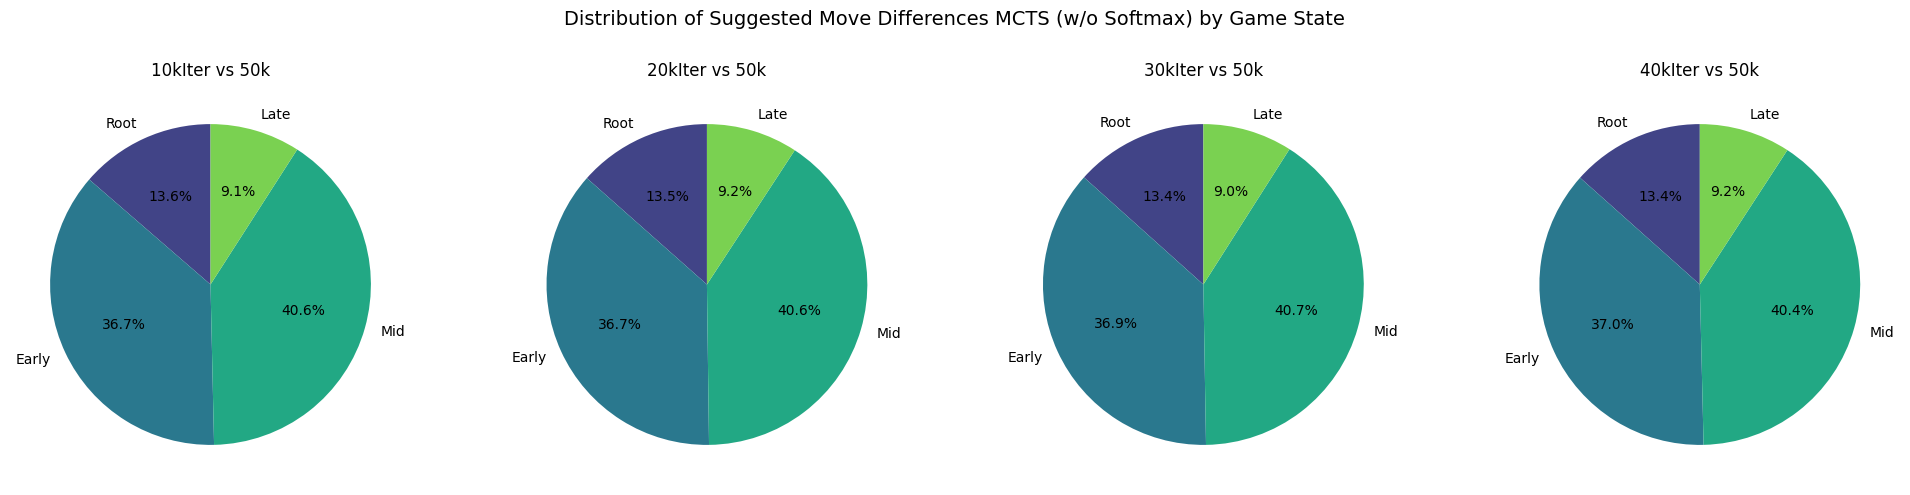

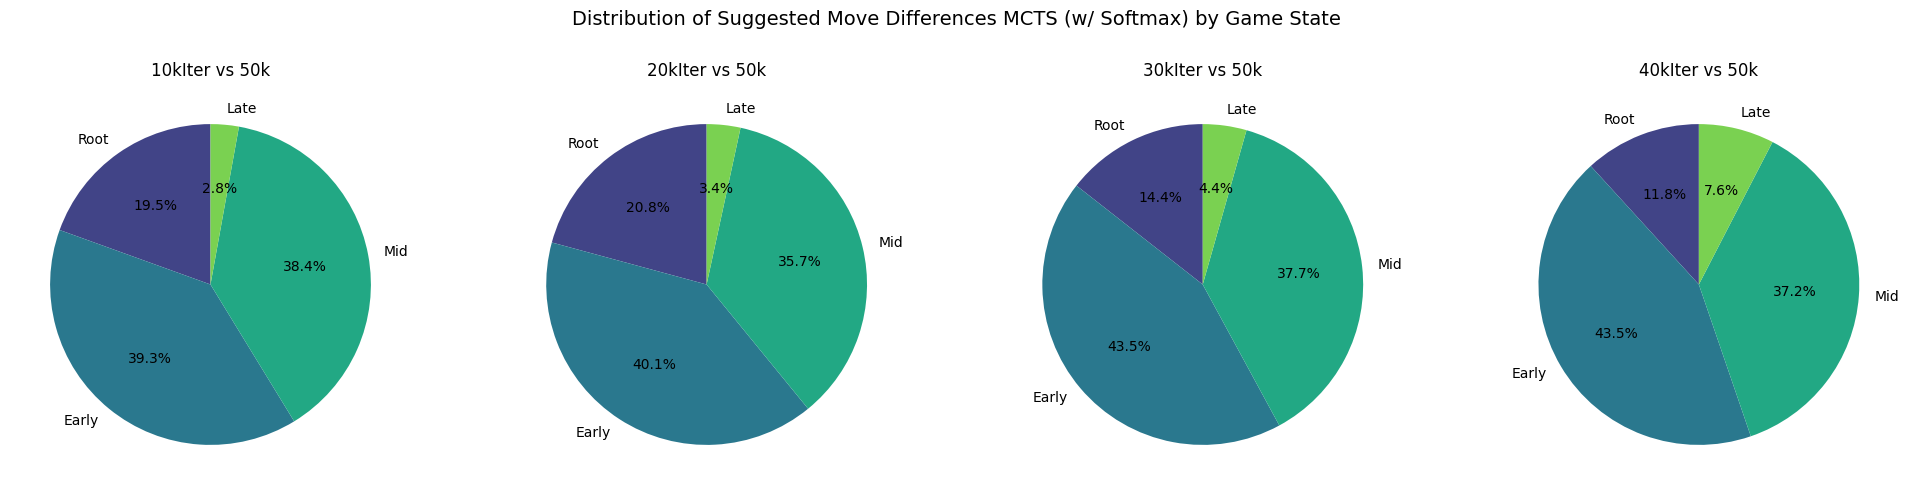

In [54]:
# Game states and associated datasets
mcts_game_states = {
    'root': mcts_root_df,
    'early': mcts_early_df,
    'mid': mcts_mid_df,
    'late': mcts_late_df
}

soft_game_states = {
    'root': soft_root_df,
    'early': soft_early_df,
    'mid': soft_mid_df,
    'late': soft_late_df
}

# Function to create pie chart figures
def plot_state_diffs(game_states, title_prefix):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for idx, iter_col in enumerate(diff_iters):
        state_counts = []
        for state_name, state_df in game_states.items():
            diff = (state_df[iter_col] != state_df['50kIter']).sum()
            state_counts.append(diff)

        axes[idx].pie(
            state_counts,
            labels=state_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('viridis', len(state_labels))
        )
        axes[idx].set_title(f'{iter_col} vs 50k')

    plt.suptitle(f'Distribution of Suggested Move Differences {title_prefix} by Game State', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Generate the two separate figures in one block
plot_state_diffs(mcts_game_states, 'MCTS (w/o Softmax)')
plot_state_diffs(soft_game_states, 'MCTS (w/ Softmax)')

## Divergence Heatmaps of Suggested Moves (vs 50k)

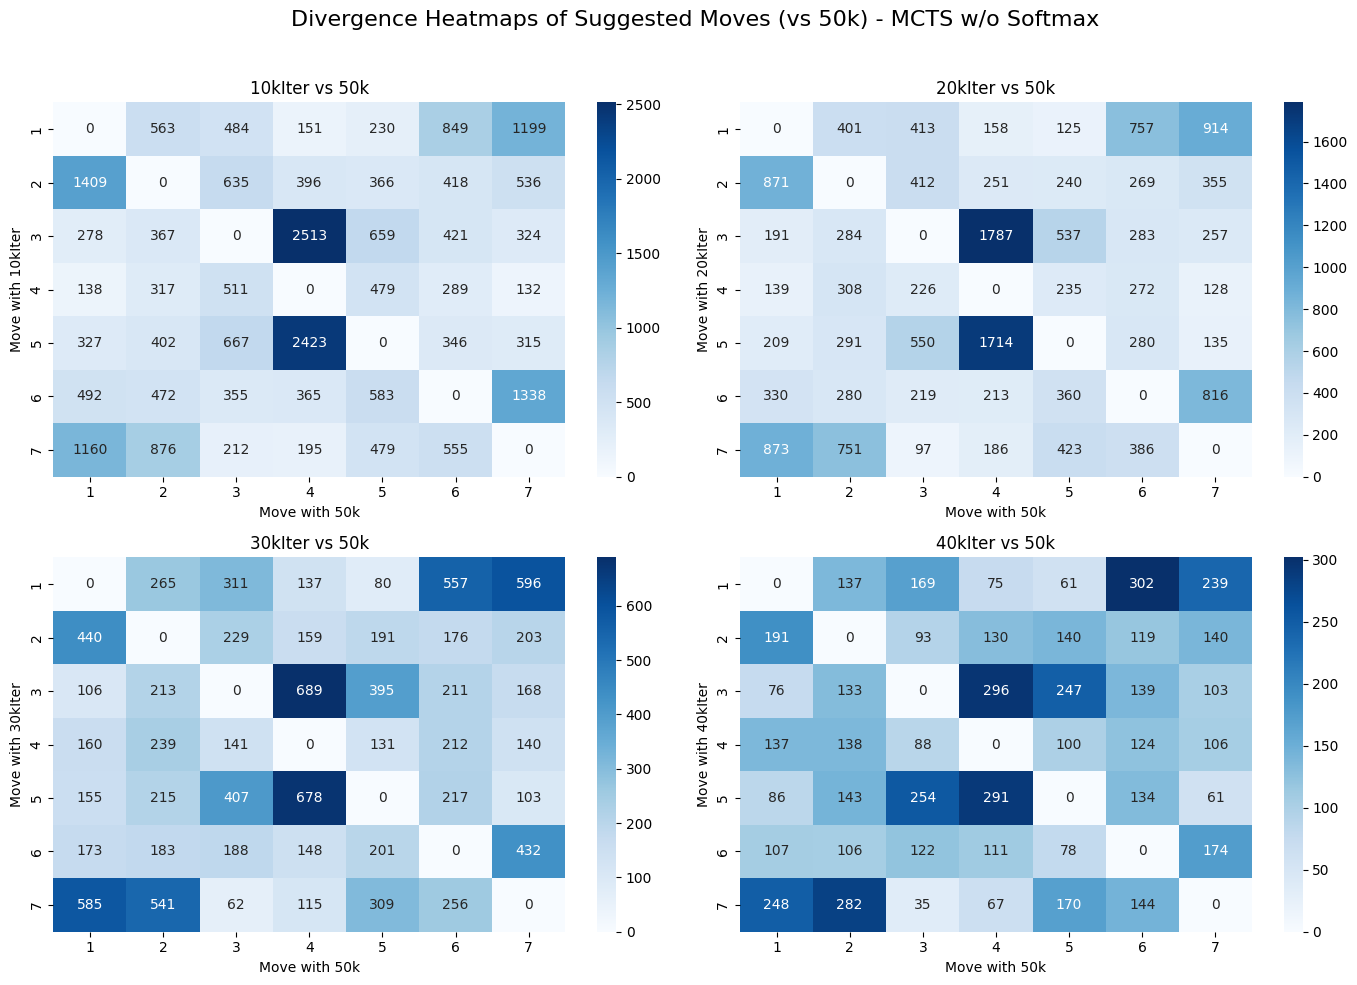

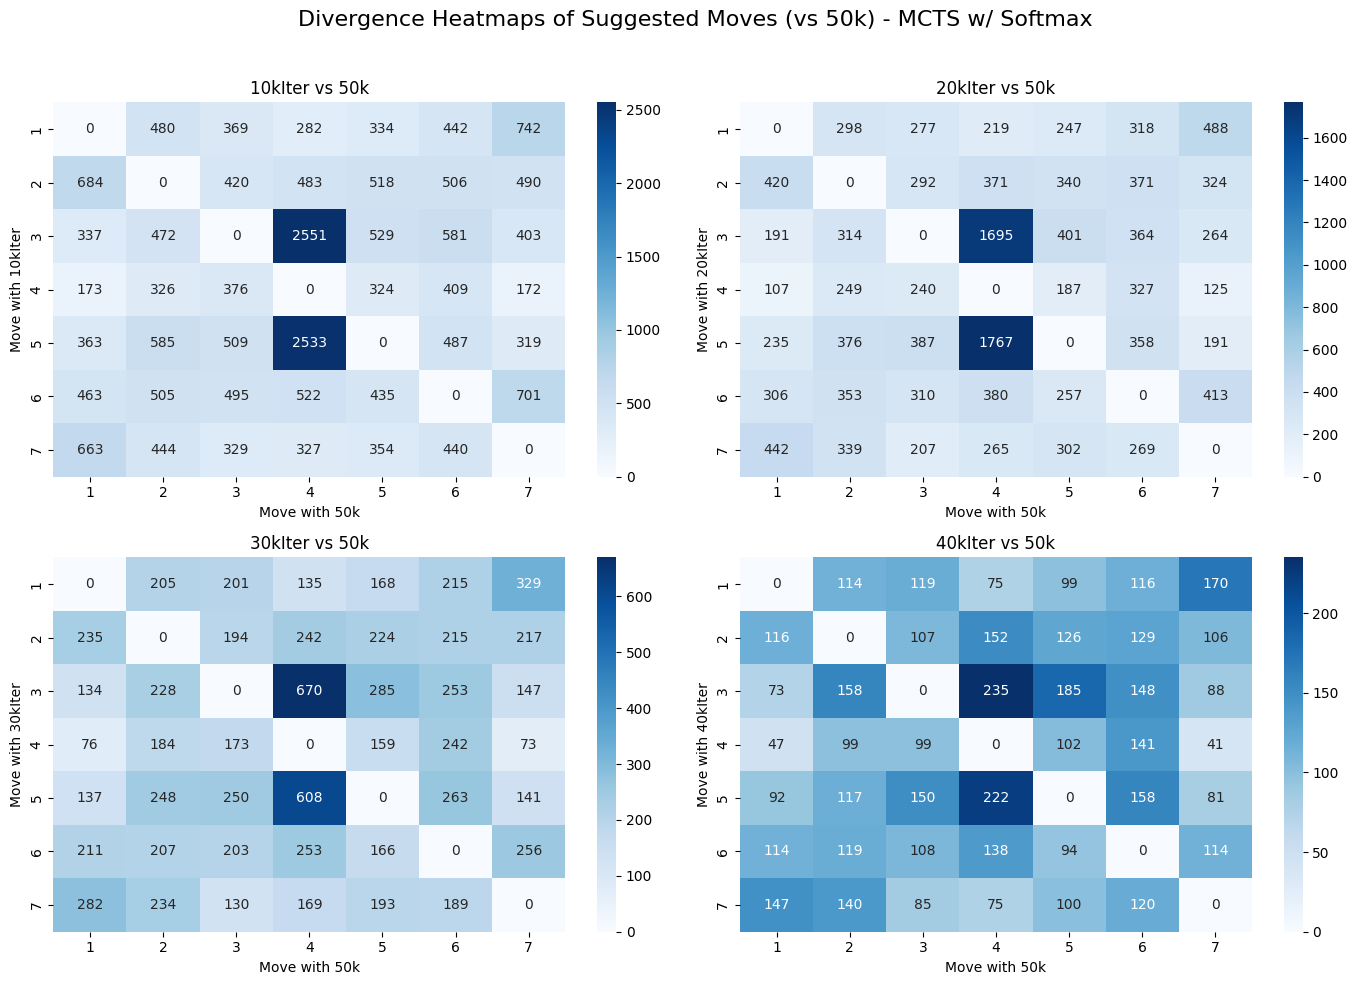

In [55]:
# Function to plot divergence heatmaps
def plot_heatmaps_vs_50k(df, title_prefix):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for i, col in enumerate(diff_iters):
        # Filter cases where the move differs
        mask = df[col] != df['50kIter']
        diff_df = df[mask]

        # Create confusion matrix
        heatmap_data = pd.crosstab(diff_df[col], diff_df['50kIter'])

        # Plot the heatmap
        sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt='d', ax=axs[i])
        axs[i].set_xlabel('Move with 50k')
        axs[i].set_ylabel(f'Move with {col}')
        axs[i].set_title(f'{col} vs 50k')

    plt.suptitle(f'Divergence Heatmaps of Suggested Moves (vs 50k) - {title_prefix}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Generate heatmaps separately
plot_heatmaps_vs_50k(mcts_df, 'MCTS w/o Softmax')
plot_heatmaps_vs_50k(soft_df, 'MCTS w/ Softmax')


The preference for columns 3 or 5 over column 4 in MCTS with fewer iterations happens because those columns might seem more promising within a shorter search horizon, whereas move 4 (center) reveals its strategic advantage only with deeper exploration.

It's as if MCTS (10k) says: *"Winning quickly here looks good!"*

While MCTS (50k) says: *"Hold on, if I play in the center, my long-term chances improve!"*

## Statistical Analysis

### Wilcoxon Test

In [57]:
def wilcoxon_test(df, iterations, method_name):
    reference = '50kIter'
    print(f"\n### Wilcoxon Test vs {reference} — {method_name} ###")
    
    for col in iterations:
        if col == reference:
            continue
        
        # Filter out rows where values differ (to avoid ValueError on identical series)
        mask = df[col] != df[reference]
        x = df.loc[mask, col]
        y = df.loc[mask, reference]
        
        if len(x) == 0:
            print(f"{col} vs {reference}: No differences found — skipped.\n")
            continue
        
        try:
            stat, p = wilcoxon(x, y)
            print(f"{col} vs {reference}:")
            print(f"→ Wilcoxon statistic = {stat:.2f}")
            print(f"→ p-value = {p:.4f} (n = {len(x)})")
            
            if p < 0.05:
                print("→ Statistically significant ✅ — Iteration behaves differently.\n")
            else:
                print("→ Not statistically significant ❌ — Similar behavior.\n")
        except ValueError as e:
            print(f"{col} vs {reference}: Test failed — {e}\n")

# Example usage:
wilcoxon_test(mcts_df, diff_iters, "MCTS (without Softmax)")
print("-" * 60)
wilcoxon_test(soft_df, diff_iters, "MCTS (with Softmax)")



### Wilcoxon Test vs 50kIter — MCTS (without Softmax) ###
10kIter vs 50kIter:
→ Wilcoxon statistic = 158653530.00
→ p-value = 0.6994 (n = 25226)
→ Not statistically significant ❌ — Similar behavior.

20kIter vs 50kIter:
→ Wilcoxon statistic = 79666624.00
→ p-value = 0.3256 (n = 17926)
→ Not statistically significant ❌ — Similar behavior.

30kIter vs 50kIter:
→ Wilcoxon statistic = 30570799.50
→ p-value = 0.3275 (n = 11117)
→ Not statistically significant ❌ — Similar behavior.

40kIter vs 50kIter:
→ Wilcoxon statistic = 9090196.00
→ p-value = 0.1398 (n = 6096)
→ Not statistically significant ❌ — Similar behavior.

------------------------------------------------------------

### Wilcoxon Test vs 50kIter — MCTS (with Softmax) ###
10kIter vs 50kIter:
→ Wilcoxon statistic = 129077231.50
→ p-value = 0.0734 (n = 22877)
→ Not statistically significant ❌ — Similar behavior.

20kIter vs 50kIter:
→ Wilcoxon statistic = 59721729.00
→ p-value = 0.0683 (n = 15586)
→ Not statistically significant ❌

In [58]:
def wilcoxon_test_by_state(dataset, method_name, state_labels, iterations, reference='50kIter'):
    print(f"\n>>> Wilcoxon tests by game state (only for differing moves):\n")

    print(f"##### {method_name.upper()} #####\n")
    
    for state_label, df_state in zip(state_labels, dataset):
        print(f"--- {state_label.upper()} ---")
        
        for col in iterations:
            if col == reference:
                continue
            
            mask = df_state[col] != df_state[reference]
            x = df_state.loc[mask, col]
            y = df_state.loc[mask, reference]

            if len(x) == 0:
                print(f"{col} vs {reference}: No differing pairs.")
                continue

            try:
                stat, p = wilcoxon(x, y)
                print(f"{col} vs {reference}: statistic = {stat:.2f}, p-value = {p:.4f} (n = {len(x)})")
            except ValueError as e:
                print(f"{col} vs {reference}: Test failed — {e}")
        
        print()

wilcoxon_test_by_state(mcts_state_datasets, "MCTS (w/o Softmax)", state_labels, diff_iters)
print("-" * 80)
wilcoxon_test_by_state(soft_state_datasets, "MCTS (w/ Softmax)", state_labels, diff_iters)



>>> Wilcoxon tests by game state (only for differing moves):

##### MCTS (W/O SOFTMAX) #####

--- ROOT ---
10kIter vs 50kIter: statistic = 2798812.50, p-value = 0.5153 (n = 3367)
20kIter vs 50kIter: statistic = 1387043.00, p-value = 0.8276 (n = 2361)
30kIter vs 50kIter: statistic = 518787.00, p-value = 0.5856 (n = 1452)
40kIter vs 50kIter: statistic = 159301.50, p-value = 0.8418 (n = 801)

--- EARLY ---
10kIter vs 50kIter: statistic = 20493896.50, p-value = 0.9051 (n = 9060)
20kIter vs 50kIter: statistic = 10244490.00, p-value = 0.3486 (n = 6444)
30kIter vs 50kIter: statistic = 3986292.50, p-value = 0.6332 (n = 4010)
40kIter vs 50kIter: statistic = 1175915.00, p-value = 0.1445 (n = 2208)

--- MID ---
10kIter vs 50kIter: statistic = 24839388.50, p-value = 0.4653 (n = 10009)
20kIter vs 50kIter: statistic = 12566692.00, p-value = 0.5957 (n = 7115)
30kIter vs 50kIter: statistic = 4891516.00, p-value = 0.9551 (n = 4425)
40kIter vs 50kIter: statistic = 1442513.50, p-value = 0.6354 (n = 2415

### Agreement

In [59]:
print("### Agreement vs 50kIter — MCTS (without Softmax) ###")
for col in diff_iters:
    match_rate = (mcts_df[col] == mcts_df[reference]).mean() * 100
    print(f"{col} vs {reference}: {match_rate:.2f}%")

print("-" * 40)

print("### Agreement vs 50kIter — MCTS (with Softmax) ###")
for col in diff_iters:
    match_rate = (soft_df[col] == soft_df[reference]).mean() * 100
    print(f"{col} vs {reference}: {match_rate:.2f}%")

### Agreement vs 50kIter — MCTS (without Softmax) ###
10kIter vs 50kIter: 70.35%
20kIter vs 50kIter: 78.93%
30kIter vs 50kIter: 86.93%
40kIter vs 50kIter: 92.83%
----------------------------------------
### Agreement vs 50kIter — MCTS (with Softmax) ###
10kIter vs 50kIter: 72.51%
20kIter vs 50kIter: 81.27%
30kIter vs 50kIter: 88.77%
40kIter vs 50kIter: 93.97%


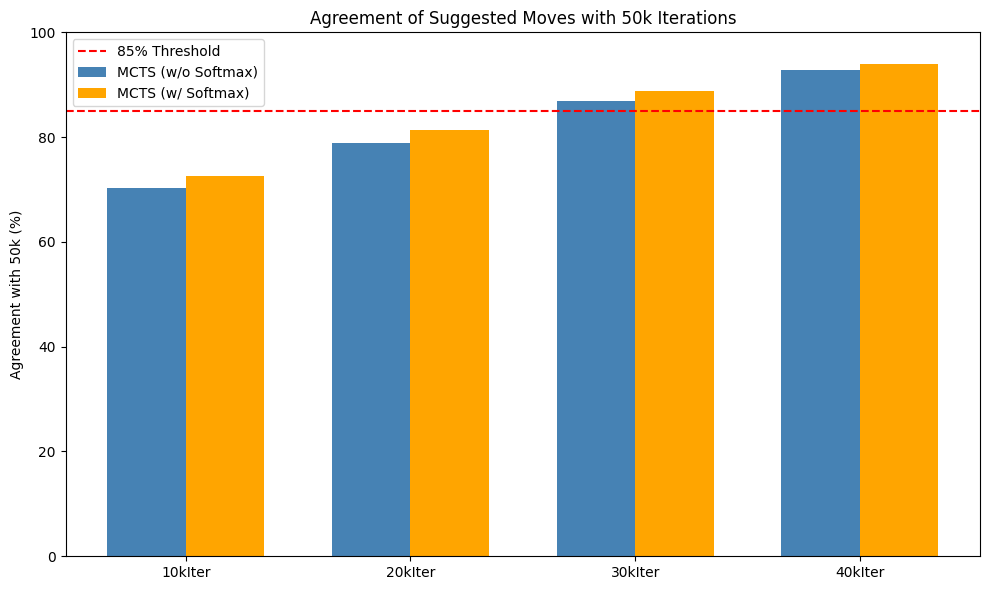

In [60]:
# Calcular taxas de concordância
mcts_match_rates = [(mcts_df[col] == mcts_df[reference]).mean() * 100 for col in diff_iters]
soft_match_rates = [(soft_df[col] == soft_df[reference]).mean() * 100 for col in diff_iters]

# Plot
import numpy as np
x = np.arange(len(diff_iters))  # posições no eixo x
width = 0.35  # largura das barras

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mcts_match_rates, width, label='MCTS (w/o Softmax)', color='steelblue')
plt.bar(x + width/2, soft_match_rates, width, label='MCTS (w/ Softmax)', color='orange')

# Linha de referência dos 85%
plt.axhline(85, color='red', linestyle='--', label='85% Threshold')

# Eixos e título
plt.xticks(x, diff_iters)
plt.ylabel('Agreement with 50k (%)')
plt.title('Agreement of Suggested Moves with 50k Iterations')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


The results show that agreement with the decisions made at 50k iterations increases steadily with more simulations.

This suggests that the algorithm gradually converges toward more consistent decisions as the number of iterations increases. However, the improvements become less significant over time. Since agreement rates above **85%** typically indicate diminishing returns, using **30k or 40k iterations** offers a good trade-off between performance and computational cost.

In [61]:
print(">>> Agreement percentage by game state and iteration - MCTS (w/o Softmax)\n")

for label, df_state in zip(state_labels, mcts_state_datasets):
    print(f"--- {label.upper()} ---")
    for col in diff_iters:
        match = (df_state[col] == df_state[reference]).mean() * 100
        print(f"{col} vs {reference}: {match:.2f}%")
    print()

print("-" * 80)
print("")

print(">>> Agreement percentage by game state and iteration - MCTS (w/ Softmax)\n")

for label, df_state in zip(state_labels, soft_state_datasets):
    print(f"--- {label.upper()} ---")
    for col in diff_iters:
        match = (df_state[col] == df_state[reference]).mean() * 100
        print(f"{col} vs {reference}: {match:.2f}%")
    print()

>>> Agreement percentage by game state and iteration - MCTS (w/o Softmax)

--- ROOT ---
10kIter vs 50kIter: 69.94%
20kIter vs 50kIter: 78.92%
30kIter vs 50kIter: 87.04%
40kIter vs 50kIter: 92.85%

--- EARLY ---
10kIter vs 50kIter: 70.58%
20kIter vs 50kIter: 79.08%
30kIter vs 50kIter: 86.98%
40kIter vs 50kIter: 92.83%

--- MID ---
10kIter vs 50kIter: 70.37%
20kIter vs 50kIter: 78.94%
30kIter vs 50kIter: 86.90%
40kIter vs 50kIter: 92.85%

--- LATE ---
10kIter vs 50kIter: 69.81%
20kIter vs 50kIter: 78.23%
30kIter vs 50kIter: 86.81%
40kIter vs 50kIter: 92.61%

--------------------------------------------------------------------------------

>>> Agreement percentage by game state and iteration - MCTS (w/ Softmax)

--- ROOT ---
10kIter vs 50kIter: 60.21%
20kIter vs 50kIter: 71.08%
30kIter vs 50kIter: 87.96%
40kIter vs 50kIter: 94.72%

--- EARLY ---
10kIter vs 50kIter: 70.84%
20kIter vs 50kIter: 79.70%
30kIter vs 50kIter: 86.80%
40kIter vs 50kIter: 92.91%

--- MID ---
10kIter vs 50kIter: 73.9

**Conclusion**

The agreement between lower iteration counts and the 50k iteration reference consistently increases across all game states for both MCTS variants (with and without Softmax). In ROOT, EARLY, and MID states, lower iteration counts (e.g., 10k and 20k) show moderate agreement—typically between **60–80%**—reflecting greater variability and uncertainty in move selection due to limited search depth.

However, from **30k iterations onward**, agreement rises sharply—often **exceeding 85%**—which suggests that additional iterations beyond this point contribute progressively less to changing the predicted best move. This convergence is particularly noticeable in the **LATE game state**, where even **10k iterations yield over 90% agreement**, likely due to the reduced complexity and more deterministic nature of endgame scenarios.

Notably, **MCTS without Softmax** demonstrates **more stable and consistent agreement across all states**, while **MCTS with Softmax** shows **greater sensitivity to the game phase**, especially in early states (e.g., ROOT), where it starts with lower agreement but converges more sharply at higher iteration counts.

Overall, these results suggest that while increasing the number of iterations improves stability and consistency of move prediction, **30k iterations appears to be a practical and efficient threshold**, balancing performance gains with computational cost.


## Wilcoxon vs Agreement

*Do they contradict each other?*  

At first glance, it might seem so — after all, the Wilcoxon tests indicate that certain iteration counts produce statistically different distributions, while the agreement levels suggest a high consistency in chosen actions. However, a closer analysis reveals that there is no contradiction, but rather a complementarity between the two metrics.


### **MCTS without Softmax**

📊 **Agreement**
- Agreement increases smoothly with iterations:  
  **10k: 70.35% → 40k: 92.83%**
- Consistent growth across all game states (ROOT, EARLY, MID, LATE)
- Even with 10k iterations, action agreement is already reasonably high.

📈 **Wilcoxon (Overall)**
- No statistically significant differences with 50kIter (p > 0.13 for all comparisons).
- Suggests that **the internal policy distribution stabilizes early**.

📈 **Wilcoxon (By Game State)**
- ROOT, EARLY, MID phases: not statistically significant.
- **LATE phase shows significance for 10k and 20k vs 50k (p < 0.02)**:
  - Indicates that even if actions match, policies diverge in late-game under lower iterations.

✅ **Conclusion**
- Without Softmax, **MCTS converges gradually and predictably**.
- Actions and policies are well-aligned even with fewer iterations.
- Some late-game divergence exists at low iterations but resolves quickly.  
  

### **MCTS with Softmax**

📊 **Agreement**
- Agreement also increases with iterations:  
  **10k: 72.51% → 40k: 93.97%**
- Less consistent across game states:
  - **ROOT starts low (60.21%)**, improves with more iterations.
  - **LATE is high from the start (~91%)**.

📈 **Wilcoxon (Overall)**
- 10k & 20k vs 50k: not statistically significant, but borderline (p ≈ 0.07).
- **30k & 40k vs 50k: significant differences (p < 0.05)**.
  - Indicates **policy distribution is still changing**, even if selected actions converge.

📈 **Wilcoxon (By Game State)**
- ROOT, EARLY, MID: mostly non-significant.
- **LATE phase shows significant differences for all comparisons (p ≈ 0.0000)**:
  - Even when agreement is >91%, visit distributions differ.
  - This happens due to Softmax amplifying small differences in visit counts.

⚠️ **Conclusion**
- With Softmax, **agreement may be misleading**: the same moves can come from different policy distributions.
- LATE phase especially prone to this, due to amplified selection effects.
- Higher iterations are needed to ensure full policy convergence.

### **Summary**

Although the agreement percentages and the Wilcoxon tests initially seem to point in different directions — one suggesting high similarity and the other indicating some statistically significant differences — they are not in conflict. Instead, they highlight different aspects of the system’s behavior. 

The agreement metric captures **how often the top move remains unchanged**, offering a **practical measure of stability** in decision-making. In contrast, the Wilcoxon test evaluates the **entire distribution of move probabilities**, detecting **subtle shifts in preference strength**, even when the final decision remains the same. 

Thus, the two metrics **complement each other**: agreement reflects robustness in action selection, while Wilcoxon reveals finer-grained differences in the search policy. Together, they provide a more nuanced and comprehensive view of how iteration count affects the behavior of MCTS.

### **Final Takeaways:** *What Is the Right Number of Iterations?*

Bringing together the statistical (Wilcoxon) and behavioral (agreement) analyses, we can draw a more grounded and practical conclusion:

- **Below 20k iterations**, both agreement percentages and Wilcoxon results suggest **noticeable instability** — the agent often changes decisions and underlying probability distributions remain in flux.
- **Between 20k and 30k iterations**, agreement improves significantly and Wilcoxon tests mostly remain non-significant, indicating a **stabilizing trend** in both decisions and policy shape.
- **From 30k onward**, agreement reaches **very high levels (~89–94%)**, and only **minor statistical differences** (mostly in Softmax and late-game states) remain. This suggests that the **core behavior of the agent is already well-formed**.
- **Using 50k iterations** offers **slight improvements**, but the **returns diminish**, especially when comparing with 30k or 40k iterations.
- **Going beyond 50k** is unlikely to yield meaningful behavioral gains, while significantly increasing computational cost.

### **Bottom line**:  
- **30k iterations appear to be a practical threshold**, balancing behavioral stability and computational efficiency. While 50k provides marginal refinements, they may not justify the cost. Unless extremely fine-grained behavior is required (e.g., in late-game precision), **30k–40k iterations should suffice** in most use cases.  

  
  
**Note:** We simulated 100 games of MCTS (30k) vs MCTS (50k), and MCTS (30k) won 88 of them. Even considering the significant advantage of playing first, these results are quite close to those of MCTS (50k) vs MCTS (50k), where the first player won 93 games. In contrast, for MCTS (10k) vs MCTS (50k), not even the first-player advantage was enough, with MCTS (10k) winning only 25 games.


## Fun Facts

### **Which column?**

### Distribution of Moves Suggested by MCTS without Softmax (10k–50k Iterations)

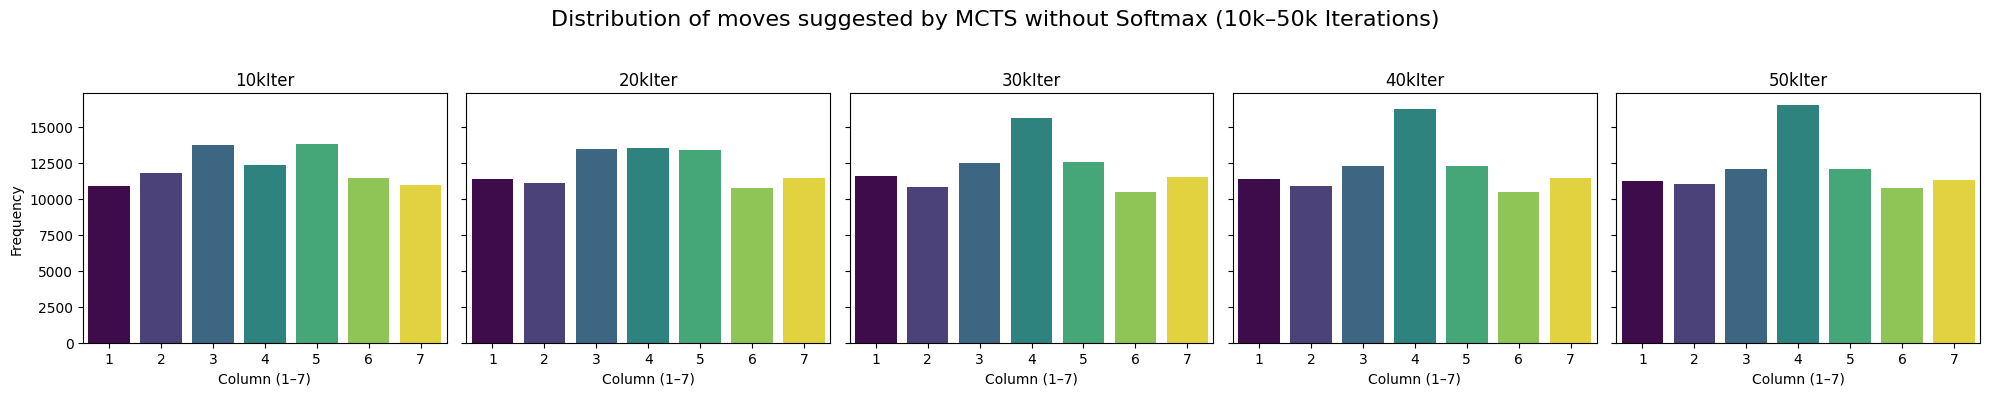

In [64]:
# Create figure and axes (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Generate each plot
for i, col in enumerate(iterations):
    sns.countplot(x=col, hue=col, data=mcts_df, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Column (1–7)')
    if i == 0:
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_ylabel('')

# Adjust layout
fig.suptitle('Distribution of moves suggested by MCTS without Softmax (10k–50k Iterations)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Distribution of Moves Suggested by MCTS with Softmax (10k–50k Iterations)

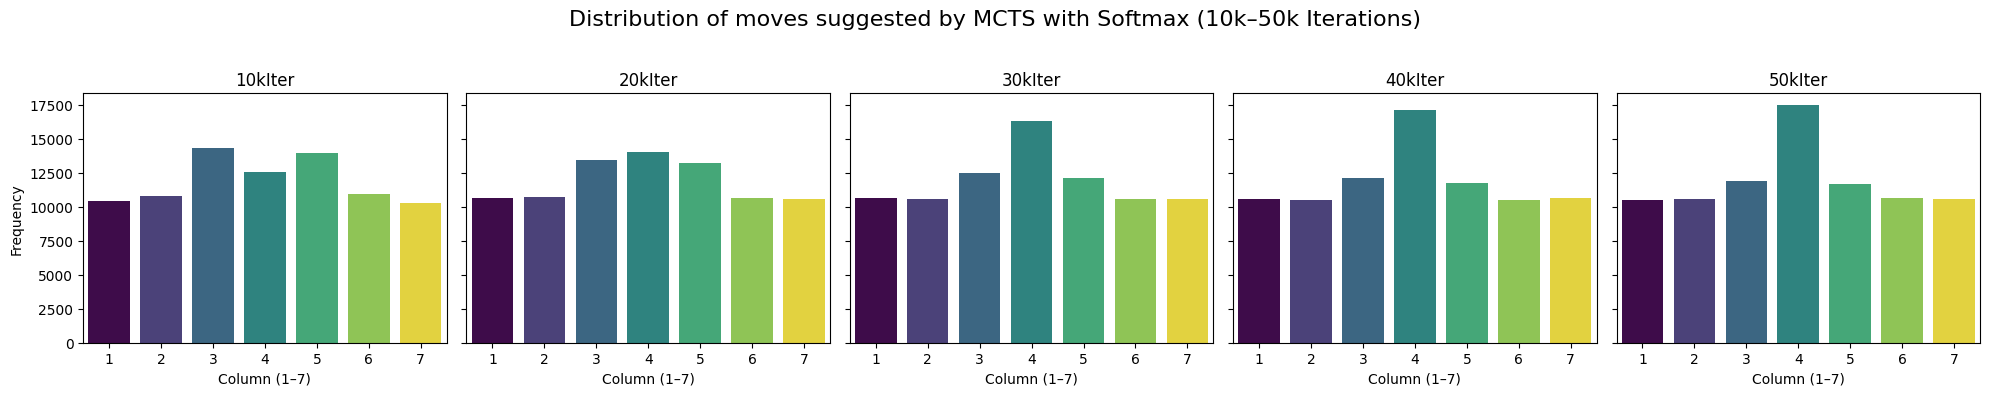

In [65]:
# Create figure and axes (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Generate each plot
for i, col in enumerate(iterations):
    sns.countplot(x=col, hue=col, data=soft_df, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Column (1–7)')
    if i == 0:
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_ylabel('')

# Adjust layout
fig.suptitle('Distribution of moves suggested by MCTS with Softmax (10k–50k Iterations)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Note:**
There are 69 different winning positions:

* 24 horizontal
* 21 vertical
* 12+12 diagonal

Out of these 69 ways to win, 51 involve placing at least one piece in the center column (4). This explains the tendency for the algorithm, as the number of iterations increases, to become aware of this and increasingly favor playing in that column.


### Left vs Right

In [62]:
def analyze_piece_distribution(df, label):
    # Initialize counters for pieces on the left, right, and center
    left_pieces = 0
    right_pieces = 0
    center_pieces = 0
    total_pieces = 0

    # Board column mappings to dataset indices
    left_indices = [0, 1, 2, 7, 8, 9, 14, 15, 16, 21, 22, 23, 28, 29, 30, 35, 36, 37]   # Columns 1, 2, 3
    right_indices = [4, 5, 6, 11, 12, 13, 18, 19, 20, 25, 26, 27, 32, 33, 34, 39, 40, 41]  # Columns 5, 6, 7
    center_indices = [3, 10, 17, 24, 31, 38]  # Column 4

    # Iterate through each row to count pieces
    for idx in range(len(df)):
        row = df.iloc[idx, :42].values  # First 42 columns represent the board

        left_pieces += np.sum(row[left_indices] != '-')
        right_pieces += np.sum(row[right_indices] != '-')
        center_pieces += np.sum(row[center_indices] != '-')
        total_pieces += np.sum(row != '-')

    # Calculate percentages
    if total_pieces > 0:
        percent_left = (left_pieces / total_pieces) * 100
        percent_right = (right_pieces / total_pieces) * 100
        percent_center = (center_pieces / total_pieces) * 100
    else:
        percent_left = percent_right = percent_center = 0

    print("-" * 40)
    print(f"### {label} ###")
    print(f"Pieces on the left: {left_pieces} ({percent_left:.2f}%)")
    print(f"Pieces on the right: {right_pieces} ({percent_right:.2f}%)")
    print(f"Pieces in the center: {center_pieces} ({percent_center:.2f}%)")

analyze_piece_distribution(mcts_df, 'MCTS w/o Softmax')
analyze_piece_distribution(soft_df, 'MCTS w/ Softmax')
analyze_piece_distribution(random_df, 'Random')
print("-" * 40)

----------------------------------------
### MCTS w/o Softmax ###
Pieces on the left: 416934 (34.41%)
Pieces on the right: 415262 (34.27%)
Pieces in the center: 379519 (31.32%)
----------------------------------------
### MCTS w/ Softmax ###
Pieces on the left: 433122 (35.01%)
Pieces on the right: 435159 (35.18%)
Pieces in the center: 368718 (29.81%)
----------------------------------------
### Random ###
Pieces on the left: 566450 (43.03%)
Pieces on the right: 566663 (43.04%)
Pieces in the center: 183348 (13.93%)
----------------------------------------


In [66]:
def analyze_side_preferences(df, label, results):
    all_moves = pd.concat([df[col] for col in results], ignore_index=True)
    
    left_moves = all_moves.isin([1, 2, 3]).sum()
    right_moves = all_moves.isin([5, 6, 7]).sum()
    center_moves = all_moves.isin([4]).sum()
    total_considered = left_moves + right_moves + center_moves
    
    percent_left = (left_moves / total_considered) * 100 if total_considered > 0 else 0
    percent_right = (right_moves / total_considered) * 100 if total_considered > 0 else 0
    percent_center = (center_moves / total_considered) * 100 if total_considered > 0 else 0
    
    print("-" * 40)
    print(f"[{label}]")
    print(f"Moves to the left (columns 1–3): {left_moves} {percent_left:.2f}%")
    print(f"Moves to the right (columns 5–7): {right_moves} {percent_right:.2f}%")
    print(f"Moves to the center (column 4): {center_moves} {percent_center:.2f}%")

# Apply the function to the main datasets
analyze_side_preferences(mcts_df, "MCTS (without Softmax)", iterations)
analyze_side_preferences(soft_df, "MCTS (with Softmax)", iterations)
analyze_side_preferences(random_df, "Random", result)
print("-" * 40)

----------------------------------------
[MCTS (without Softmax)]
Moves to the left (columns 1–3): 176391 41.47%
Moves to the right (columns 5–7): 174777 41.09%
Moves to the center (column 4): 74212 17.45%
----------------------------------------
[MCTS (with Softmax)]
Moves to the left (columns 1–3): 170108 40.89%
Moves to the right (columns 5–7): 168535 40.51%
Moves to the center (column 4): 77397 18.60%
----------------------------------------
[Random]
Moves to the left (columns 1–3): 42621 47.89%
Moves to the right (columns 5–7): 28668 32.21%
Moves to the center (column 4): 17711 19.90%
----------------------------------------


**Note:** favoring one side in move selection does not necessarily mean that victories occur more often on that same side. In many cases, one side becomes overloaded because the player is actively avoiding moves on the other side, which could eventually lead to the opponent’s victory.